# Version Control
- V00: follow F.Chollet [使用非常少的数据构建强大的图像分类模型](https://github.com/ictar/python-doc/blob/master/Machine%20Learning/使用非常少的数据构建强大的图像分类模型.md) & [秉叡](https://drive.google.com/open?id=1-wHQCF9mkj_3CLewJ9MbtlT9MhWS1fw5)

# CODE

In [1]:
import os, glob, csv
# from random import shuffle
# from collections import Counter
# import h5py, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam, RMSprop

# 顯示每一項 var.  的 output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Using TensorFlow backend.


In [2]:
# 設定路徑
# from google.colab import drive
# drive.mount('/content/gdrive')
# path_wrt = '/content/gdrive/My Drive/projects/oil_king'
path_wrt = 'C:\\Users\\USER\\Google 雲端硬碟\\projects\\oil_king'
# path_train = '/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/train'
# path_train = 'D:\\OilKing\\train0131'
# path_train = r'C:\Users\USER\Google 雲端硬碟\Datasets\WhereAmI\train'
path_train = r'C:\Users\USER\Google 雲端硬碟\Datasets\the-simpsons-characters-dataset\simpsons_dataset'

os.chdir(path_wrt)


In [3]:
# 生成 data augmentation 的 generator
datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1./255,
            rotation_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
)

img_size = (128,128)
batch_size = 8
color_mode = 'rgb' # One of "grayscale", "rbg", "rgba"
if color_mode=="grayscale":
    img_channels = 1
else:
    img_channels = len(color_mode)
input_shp = tuple(list(img_size)+[img_channels]) # example: (224, 224, 3)
print("train/validation: ", input_shp)

trn_generator = datagen.flow_from_directory(
                    path_train, target_size=img_size, batch_size=batch_size,
                    #save_to_dir=path_wrt +"/aug",
                    save_prefix="trn+",
                    subset="training"
)
val_generator = datagen.flow_from_directory(
                    path_train, target_size=img_size, batch_size=batch_size,
                    #save_to_dir=path_wrt +"/aug",
                    save_prefix="val+",
                    subset="validation"
)
i = 0
map_labels = {}
for path in os.listdir(path_train):
    if os.path.isdir(path_train+"/"+path):
        map_labels[i] = path
        i+=1
print(map_labels)

num_labels = len(map_labels)

train/validation:  (128, 128, 3)
Found 15717 images belonging to 47 classes.
Found 5216 images belonging to 47 classes.
{0: 'abraham_grampa_simpson', 1: 'agnes_skinner', 2: 'apu_nahasapeemapetilon', 3: 'barney_gumble', 4: 'bart_simpson', 5: 'bumblebee_man', 6: 'carl_carlson', 7: 'charles_montgomery_burns', 8: 'chief_wiggum', 9: 'cletus_spuckler', 10: 'comic_book_guy', 11: 'disco_stu', 12: 'edna_krabappel', 13: 'fat_tony', 14: 'gil', 15: 'groundskeeper_willie', 16: 'hans_moleman', 17: 'helen_lovejoy', 18: 'homer_simpson', 19: 'jasper_beardly', 20: 'jimbo_jones', 21: 'kent_brockman', 22: 'krusty_the_clown', 23: 'lenny_leonard', 24: 'lionel_hutz', 25: 'lisa_simpson', 26: 'maggie_simpson', 27: 'marge_simpson', 28: 'martin_prince', 29: 'mayor_quimby', 30: 'milhouse_van_houten', 31: 'miss_hoover', 32: 'moe_szyslak', 33: 'ned_flanders', 34: 'nelson_muntz', 35: 'otto_mann', 36: 'patty_bouvier', 37: 'principal_skinner', 38: 'professor_john_frink', 39: 'rainier_wolfcastle', 40: 'ralph_wiggum', 4

In [4]:
# # 展示 showcase of ImageDataGenerator
# img = load_img(path_train_flat +"/" + os.listdir(path_train_flat)[0])  # this is a PIL image

# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, batch_size=1,
#                           save_to_dir= path_wrt + '/datagen_samples',
#                           save_prefix='show01',
#                           save_format='jpg',
#                          ):
#     i += 1
#     if i > 10:
#         break  # otherwise the generator would loop indefinitely

In [5]:
# 定義訓練模型


In [6]:
# model_base 
#-------------------
# 0: 簡單 CNN model
# https://github.com/ictar/python-doc/blob/master/Machine%20Learning/使用非常少的数据构建强大的图像分类模型.md
base_0 = Sequential()
base_0.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shp))
base_0.add(MaxPooling2D(pool_size=(2, 2)))

base_0.add(Conv2D(32, (3,3), padding='same', activation='relu'))
base_0.add(MaxPooling2D(pool_size=(2, 2)))

base_0.add(Conv2D(64, (3,3), padding='same', activation='relu'))
base_0.add(MaxPooling2D(pool_size=(2, 2)))
# the model so far outputs 3D feature maps (height, width, features)

# 1: 模仿 VGG16 的 CNN model
base_1 = Sequential()
base_1.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shp))
base_1.add(Conv2D(64, (3,3), padding='same', activation='relu'))
base_1.add(MaxPooling2D(pool_size=(2, 2)))

base_1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
base_1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
base_1.add(MaxPooling2D(pool_size=(2, 2)))

base_1.add(Conv2D(256, (3,3), padding='same', activation='relu'))
base_1.add(Conv2D(256, (3,3), padding='same', activation='relu'))
base_1.add(MaxPooling2D(pool_size=(2, 2)))

base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
base_1.add(MaxPooling2D(pool_size=(2, 2)))

base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
base_1.add(Conv2D(512, (3,3), padding='same', activation='relu'))
base_1.add(MaxPooling2D(pool_size=(2, 2)))

# 2: Keras Applications
base_vgg16 = keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet', input_shape=input_shp, classes=num_labels)
base_resnet = keras.applications.resnet50.ResNet50(
                include_top=False, weights='imagenet', input_shape=input_shp, classes=num_labels)
base_mobilenet = keras.applications.mobilenet.MobileNet(
                include_top=False, weights='imagenet', input_shape=input_shp, classes=num_labels)

# model_top
#-------------------
# 0: 簡單 CNN model
# https://github.com/ictar/python-doc/blob/master/Machine%20Learning/使用非常少的数据构建强大的图像分类模型.md
top_0 = Sequential()
top_0.add(Flatten())
top_0.add(Dense(64, activation='relu'))
top_0.add(Dropout(0.5))
top_0.add(Dense(num_labels, activation='softmax'))

# 1: BatchNormalization
top_1 = Sequential()
top_1.add(Flatten())
top_1.add(BatchNormalization())
top_1.add(Dense(64, activation='relu'))
top_1.add(BatchNormalization())
top_1.add(Dense(num_labels, activation='softmax'))

print("Loading models......Done!")

D:\Anaconda3\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Loading models......Done!


In [7]:
# compile & fit
#-----------------
base = base_vgg16; base.trainable=False
top = top_1

model = Sequential()
model.add(base)
model.add(top)

model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
)

stepX = 2
history = model.fit_generator(
                    trn_generator,
                    validation_data=val_generator,
                    epochs=10,
                    steps_per_epoch=len(trn_generator)*stepX,
                    validation_steps=len(val_generator)*stepX,
)

Epoch 1/10
3930/3930 [==============================] - 379s 96ms/step - loss: 1.9023 - acc: 0.5118 - val_loss: 1.6981 - val_acc: 0.5636
Epoch 2/10
3930/3930 [==============================] - 376s 96ms/step - loss: 1.4958 - acc: 0.6050 - val_loss: 1.6676 - val_acc: 0.5767
Epoch 3/10
3930/3930 [==============================] - 377s 96ms/step - loss: 1.4208 - acc: 0.6291 - val_loss: 1.6171 - val_acc: 0.5918
Epoch 4/10
3930/3930 [==============================] - 377s 96ms/step - loss: 1.3690 - acc: 0.6451 - val_loss: 1.6135 - val_acc: 0.5988
Epoch 5/10
3930/3930 [==============================] - 377s 96ms/step - loss: 1.3517 - acc: 0.6498 - val_loss: 1.6154 - val_acc: 0.5929
Epoch 6/10
3930/3930 [==============================] - 376s 96ms/step - loss: 1.3236 - acc: 0.6607 - val_loss: 1.6198 - val_acc: 0.5959
Epoch 7/10
3930/3930 [==============================] - 377s 96ms/step - loss: 1.2886 - acc: 0.6692 - val_loss: 1.6364 - val_acc: 0.5942
Epoch 8/10
3930/3930 [===================

In [8]:
base.summary()
top.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

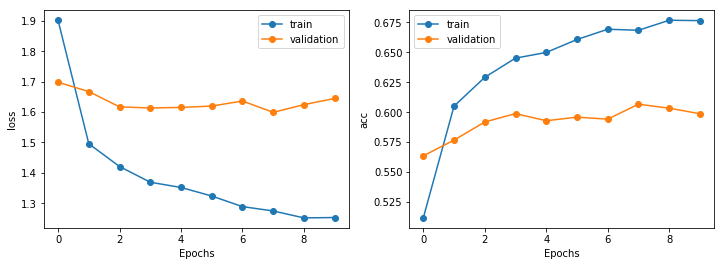

In [9]:
 # 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);plot_train_history(history, 'loss','val_loss')
plt.subplot(1,2,2);plot_train_history(history, 'acc','val_acc')
fig = plt.gcf()# gcf: Get Current Figure
plt.show();